In [ ]:
# Coursework 1: Stochastic Differential Equations

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

Consider the Ornstein-Uhlenbeck problem

$$
\begin{equation}
  dX_t = -\lambda X_t \, dt + \mu \, dW_t.
\end{equation}
$$

## Setup

Using standard ODE techniques such as variation of parameters we can show that its solution is

\begin{equation}
  X_t = e^{-\lambda t} X_0 + \mu \int_0^t e^{-\lambda (t - s)} \, dW_s.
\end{equation}

In addition, if we assume that $g$ is a deterministic function, then using the two identities

\begin{align}
  \mathbb{E} \left\{ \int_0^t g(s) \, dW_s \right\} & = 0, \\
  \mathbb{E} \left( \left\{ \int_0^t g(s) \, dW_s \right\}^2 \right) & = \int_0^t g^2(s) \, ds,
\end{align}

we can calculate $\mathbb{E}(X_t)$ and $\mathbb{E}(X_t^2)$ as


\begin{align}
  \mathbb{E}(X_t) & = e^{-\lambda t} X_0, \\
  \mathbb{E}(X_t^2) & = e^{-2\lambda t} X_0^2 + \frac{\mu^2}{2 \lambda} \left( 1 - e^{-2 \lambda t} \right).
\end{align}

In particular we can show that

\begin{equation}
  \lim_{t \to \infty} X_t \sim N \left( 0, \frac{\mu^2}{2 \lambda} \right).
\end{equation}

In [71]:
def ito(h, mrange, dw=None, seed=100):
    """Compute the Ito stochastic integral given the range of t.
    
    Parameters
    ----------
    
    h           function
            Function to be integrated
    mrange      list of float
            The range of integration
    dW          array of float
            Brownian increments
    seed        Integer
            Optional seed for the Brownian path
    Returns
    -------
    
    ito         float
            The integral
    """
    N = len(mrange)
    if dw==None:
        np.random.seed(seed=seed)
        dw = (np.random.rand(N) - 0.5)*np.sqrt(1/float(N))
    ito = np.sum(h(mrange)*dw)
    return ito

In [72]:
def euler_maruyama(trange, l=3.0, mu=1.0, X0=1.0, R=4, dw=None, seed=100):
    """
    Return the solutions to the Ornstein-Uhlenbeck using the Euler-Maruyama method.
    
    Parameters
    ----------
    trange      vector of float
            The range of points
    l           float
            Coefficient
    mu          float
            Coefficient
    X0          float
            Initial Value
    R           int
            Time step multiplier
    dw          array of float
            Random number container for the stochastic process
    seed        float
            Pseudo-random number seed
    
    Returns
    -------
    T           array of float
            Time intervals
    em          array of float
            Solution vector
    """
    assert type(trange)==np.ndarray,\
        "The input vector with the range of points should be a numpy array"
    N = len(trange)
    R = int(R)
    DT = R * (trange[1] - trange[0])
    L = int(N/R)
    np.random.seed(seed=seed)
    if dw==None:
        dw = (np.random.rand(N-2) - 0.5)*np.sqrt(1/float(N))
    xt = X0
    em = np.zeros(L)
    for i in np.arange(L):
        Winc = np.sum(dw[R * (i-1) + 1 : R * i])
        xt = xt - l*DT*xt + mu*Winc
        em[i] = xt
    T = np.linspace(trange[0], trange[-1], L)
    return T, em

## Question 1

Solve the Ornstein-Uhlenbeck problem using the Euler-Maruyama method for $X_0 = 1, T=1, \lambda=1, \mu=1$ and different timesteps (suggest using $2^{4, \dots 10}$). What is the weak order of convergence? (Use $p(X) = X^2$).

/home/kostas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


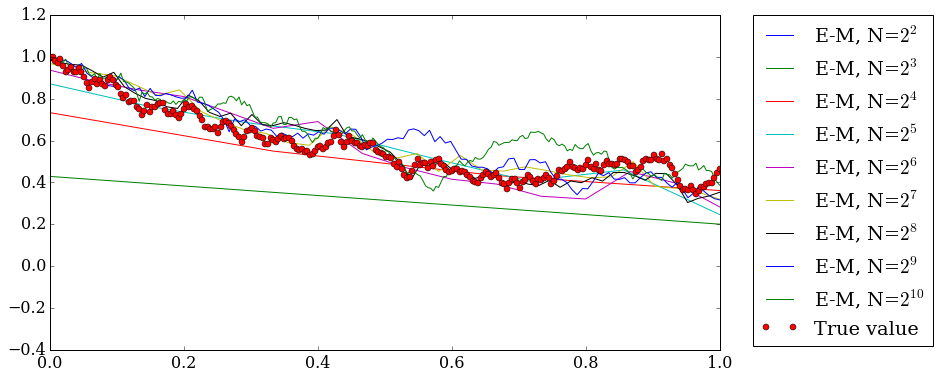

In [91]:
# Parameters
T = 1.0
lamda = 1.0
mu = 1.0
X0 = 1.0

def true_sol(tr, l, mu, X0, seed=100):
    """
    Returns the true solution
    """
    N=len(tr)
    np.random.seed(seed=seed)
    dw = (np.random.rand(N) - 0.5)*np.sqrt(1/float(N))
    myF = lambda s: np.exp(l*s)
    
    sol = np.zeros(N)
    for i, t in enumerate(tr):
        sol[i] = np.exp(-l*t) * (X0 + ito(myF, tr[:i], dw[:i]))
    return sol

# Create plots
for i in np.arange(2, 11):
    trange = np.linspace(0.0, T, num=2**i)
    t, em = euler_maruyama(trange, l=lamda, mu=mu, X0=X0, R=4)
    plt.plot(t, em, label=r"E-M, N=$2^{%i}$" %(i))
OU = true_sol(t, l=lamda, mu=mu, X0=X0)
plt.plot(t, OU, 'o', label="True value")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Question 2

Now consider $T=10$ and perform $10^5$ realizations for each time step $h$ (your choice of timestep). Plot a histogram of $X^{(h)}(T)$ for one given $h$. How is it distributed?

You should be able to show (numerically, by varying $h$ and computing the mean of your result) that

$$
\begin{equation}
  X^{(h)}(T) \sim N \left( 0, \frac{\mu^2}{2 \lambda - \lambda^2 h} \right) \qquad \text{for large } T.
\end{equation}
$$

## Question 3

Now consider the following discretization of the Ornstein-Uhlenbeck problem:

$$
\begin{equation}
  X_{n+1} = X_n - \lambda h \theta X_{n+1} - \lambda h (1 - \theta) X_n + \mu \Delta W_n
\end{equation}
$$

with $\theta = 1/2$.

Use the parameters $T=1, \lambda=1, \mu=1$. What is the order of weak convergence? (Again use $p(X) = X^2$; going above $10^5$ realizations is probably too costly, which will limit the ability to get a reliable answer).

In [11]:
# Parameters
T = 0.1
lamda = 1.0
mu = 1.0

## Question 4

Consider now $T \gg 1$ (essentially $T=10$) and repeat the procedure in question 2. Suggest why the behaviour of the distribution of the results with $h$ is different from question 2.